In [1]:
! pip install ./python_files
from python_files import *
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

Processing c:\users\tbird\documents\github\06-665-psm-final-project\python_files
  Created wheel for python-files: filename=python_files-0.1.0-py3-none-any.whl size=1023 sha256=1b257e75b1aca68f8a01fab8bb4b1d76e8b36dd4f454d862644c91381a93844e
  Stored in directory: C:\Users\tbird\AppData\Local\Temp\pip-ephem-wheel-cache-swcy8y55\wheels\ca\c1\3d\7f33f532b3f9eddd59bbd2ddd1f7583d50a6829274a8d07efa
Successfully built python-files
  Attempting uninstall: python-files
    Found existing installation: python-files 0.1.0
    Uninstalling python-files-0.1.0:
      Successfully uninstalled python-files-0.1.0


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


GPU is available, training on:  NVIDIA GeForce RTX 2070 Super with Max-Q Design


# Training the NN

### Getting data for the NN training

num_timesteps = 500
1/2
ODE solution found: True
2/2
ODE solution found: True
Saved: 
2_solutions.npy: (2, 6, 500)
2_F_ag.npy: (2, 500)


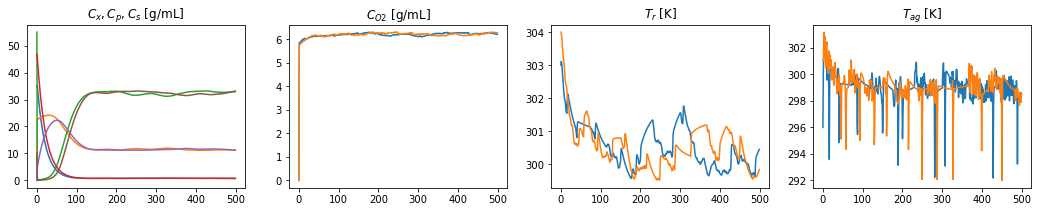

In [2]:
N = 2
solutions_name = str(N) + "_solutions.npy"
F_ag_array_name = str(N) + "_F_ag.npy"
save_dir = "./saved"
os.makedirs (save_dir, exist_ok=True)

num_timesteps = 500
train_random_inputs = generate_inputs (N)
solutions, F_ag_array = generate_ode_data(train_random_inputs, num_timesteps)

print ("="*50)
print ("Saved: ")
print (f"{solutions_name}: {solutions.shape}")
print (f"{F_ag_array_name}: {F_ag_array.shape}")
print ("="*50)

# SAVE
np.save (join(save_dir, solutions_name), solutions)
np.save (join(save_dir, F_ag_array_name), F_ag_array)

# PLOT
plot_ode_solutions (solutions)

### Visualizing input and output sequences like the paper shows on page ___

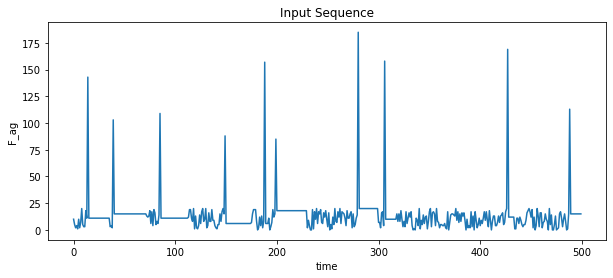

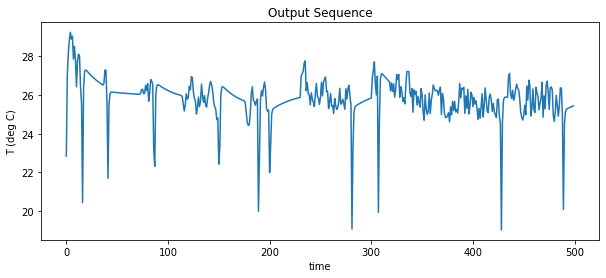

In [3]:
plt.figure(figsize = (10,4))
plt.title("Input Sequence")
plt.xlabel("time")
plt.ylabel("F_ag")
# plt.xlim(100,500)
plt.plot(F_ag_array[0,:])
plt.show()

plt.figure(figsize=(10,4))
plt.title("Output Sequence")
plt.xlabel("time")
# plt.xlim(100,500)
# plt.ylim(26,34)
plt.ylabel("T (deg C)")
plt.plot(solutions[0][-1].T - 273.15)
plt.show()

(2, 7, 500)
pre-processing data...
n: 0 data shape: (2, 7, 500)
preprocessing done
n: 0 data shape: torch.Size([1, 497, 9]) data.shape[1]: 497
predicted_current_temp: 2.6579794883728027 ground_truth: 302.7336730957031
predicted_current_temp: 65.75811767578125 ground_truth: 302.5545349121094
predicted_current_temp: 142.40599060058594 ground_truth: 302.3694152832031
predicted_current_temp: 0.4609944820404053 ground_truth: 0.0
predicted_current_temp: 0.5486043691635132 ground_truth: 0.0
predicted_current_temp: 0.6140007972717285 ground_truth: 0.0
predicted_current_temp: 0.6440931558609009 ground_truth: 0.0
predicted_current_temp: 0.6235260963439941 ground_truth: 0.0
predicted_current_temp: 0.53919517993927 ground_truth: 0.0
predicted_current_temp: 0.38327014446258545 ground_truth: 0.0
predicted_current_temp: 0.17920584976673126 ground_truth: 0.0
predicted_current_temp: -0.017914295196533203 ground_truth: 0.0
predicted_current_temp: -0.17615906894207 ground_truth: 0.0
predicted_current_tem

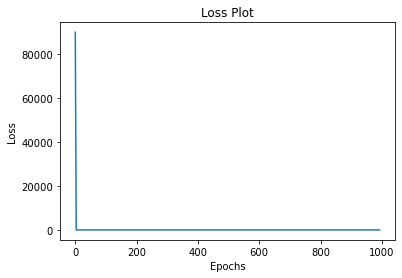

In [4]:
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(N,1,num_timesteps)), axis=1)
print(solutions_w_F_ag.shape)
train_data = data_preprocessing(solutions_w_F_ag, N = N, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("preprocessing done")

model = NeuralNet(num_hidden_layers = 2, input_size = 8, hidden_size = 64, output_size = 1)#, device = device)
train(model, train_data, optimizer = "Adam", num_epochs = 1)

### Testing the NN

num_timesteps = 500
1/1
ODE solution found: True
Saved: 
1test_solutions.npy: (1, 6, 500)
1test_F_ag.npy: (1, 500)


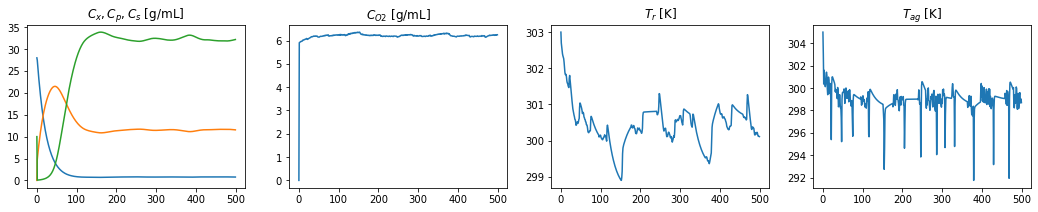

In [5]:
N = 1
test_solutions_name = str(N) + "test_solutions.npy"
test_F_ag_array_name = str(N) + "test_F_ag.npy"
save_dir = "./saved"
os.makedirs (save_dir, exist_ok=True)


test_random_inputs = generate_inputs (N)
test_solutions, test_F_ag_array = generate_ode_data(test_random_inputs, num_timesteps=500)

print ("="*50)
print ("Saved: ")
print (f"{test_solutions_name}: {test_solutions.shape}")
print (f"{test_F_ag_array_name}: {test_F_ag_array.shape}")
print ("="*50)

# SAVE
np.save (join(save_dir, test_solutions_name), test_solutions)
np.save (join(save_dir, test_F_ag_array_name), test_F_ag_array)

# PLOT
plot_ode_solutions (test_solutions)

In [6]:
test_solutions_w_F_ag = np.concatenate((test_solutions, test_F_ag_array.reshape(N,1,num_timesteps)), axis=1)
print(test_solutions_w_F_ag.shape)
test_data = data_preprocessing(test_solutions_w_F_ag,N = N, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
# print(test_data.size)

test(model, test_data)

(1, 7, 500)
pre-processing data...
n: 0 data shape: (1, 7, 500)
n: 0 data shape: torch.Size([1, 497, 9]) data.shape[1]: 497
predicted_current_temp: 2870.838623046875 ground_truth: 302.39776611328125


AttributeError: 'float' object has no attribute 'size'